In [1]:
#Initialization for HateSpeechRecognition
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
import nltk
import re
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import zero_one_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import t
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/mufa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mufa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mufa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def nested_kfold_cv(clf, param_grid, X, y, k1=10, k2=3):
    
    err = []
    kfold = KFold(n_splits=k1, shuffle=True, random_state=42)
    
    # Outer loop
    for ind_train, ind_test in kfold.split(X):
        
        X_train, y_train, X_test, y_test = X[ind_train], y[ind_train], X[ind_test], y[ind_test]
        
        # Inner loop
        inn = GridSearchCV(clf,param_grid,n_jobs=5, cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2).fit(X_train, y_train)
        
        # Prediction based on the best selected params, the ones that minimize average error
        h = inn.best_estimator_.fit(X_train, y_train).predict(X_test)
        
        err.append(zero_one_loss(y_test, h))
        print(classification_report( y_test, h ))
    return err

In [3]:

def clean_text(rgx_list, text):
    new_text = text
    for rgx_match in rgx_list:
        new_text = re.sub(rgx_match, '', new_text)
    return new_text

In [4]:
def get_common_words(content):
    ret_list = []
    fdist2 = nltk.FreqDist(content)
    most_list = fdist2.most_common(75)
    for x in most_list:
        ret_list.append(x)
    return ret_list

In [5]:

stopwords_list = stopwords.words('english')
#other_exclusions = ["#ff", "ff", "rt","!",":","...",".","-","&","?"]
#stopwords_list.extend(other_exclusions)

dataset = pd.read_csv("dataset/labeled_data.csv")

tweets = dataset.tweet

ps = nltk.stem.PorterStemmer()

#ps.stem(dataset)

#Text cleaning and tokenization, then stemming then POS tagging
filtered_tweets=[];
tweet_tags = [];
filtered_tweets_stemmed=[];
common_words_prepare=[];

for tweet in tweets:
    tweet = clean_text(["http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",".*@.*:","&#*\w*","@[\w\-]+","[^\w\s]"],tweet)
    tweet = tweet.lower()
    word_tokens = word_tokenize(tweet)
    common_words = get_common_words(word_tokens)
    for word in common_words:
        common_words_prepare.append(word)
    filtered_tweets.append([word for word in word_tokens if not word in stopwords_list])
    filtered_tweets_stemmed.append([ps.stem(word) for word in word_tokens if not word in stopwords_list])
    
for tweet in filtered_tweets:
    tweet_tags.append(nltk.pos_tag(tweet))
    


In [36]:
# Izbacivanje frequent wordsa

common_words = get_common_words(common_words_prepare)
#for word in filtered_tweets[1:100]:
#    print(word)
common = []
for word in common_words[1:50]:
   common.append(word[0][0])

filtered_tweets_no_common = [];
filtered_tweets_no_common_stemmed = [];
for line in filtered_tweets:
    filtered_tweets_no_common.append([word for word in line if not word in common])
    filtered_tweets_no_common_stemmed.append([ps.stem(word) for word in line if not word in common])
#print("---------------------------")
#for word in filtered_tweets_no_common[1:100]:
#    print(word)
    

In [37]:
#Creating TfIdf vectorizer
ftss=[]
for tweet in filtered_tweets_no_common_stemmed:
    ftss.append(' '.join(tweet))

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,3),lowercase=False,max_features=1000,smooth_idf=False,norm=None,max_df=0.75,min_df=5)



In [38]:
X = vectorizer.fit_transform(ftss).toarray()
Y = dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.3)



In [15]:
#SVM Classifier
C = [ 2e-2, 2e-1, 2e-0]
gama = [ 2e-2, 2e-1, 2e-0]
param = [{'svc__kernel': ['rbf'], 'svc__C': C}]
clf = svm.SVC(decision_function_shape='ovo')
scale = StandardScaler()
pipeline = Pipeline([('scaler', scale), ('svc', clf)])

svm_err = nested_kfold_cv(pipeline, param, X, Y)
#param_grid = [{}] 
#grid_search = GridSearchCV(pipeline, 
#                           param_grid,
#                          n_jobs = 5,
#                           cv=StratifiedKFold(n_splits=5, 
#                                              random_state=42).split(X_train, y_train), 
#                           verbose=2)
#model = grid_search.fit(X_train,y_train)
#y_pred = model.predict(X_test)
#report = classification_report( y_test, y_pred )
#print(report)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 69.7min finished


             precision    recall  f1-score   support

          0       0.48      0.12      0.19       164
          1       0.84      0.97      0.90      1905
          2       0.79      0.44      0.56       410

avg / total       0.80      0.82      0.80      2479

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 69.8min finished


             precision    recall  f1-score   support

          0       0.38      0.16      0.22       127
          1       0.84      0.97      0.90      1927
          2       0.82      0.42      0.56       425

avg / total       0.82      0.83      0.81      2479

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 67.9min finished


             precision    recall  f1-score   support

          0       0.45      0.10      0.17       136
          1       0.84      0.97      0.90      1916
          2       0.81      0.45      0.58       427

avg / total       0.82      0.84      0.81      2479

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 69.3min finished


             precision    recall  f1-score   support

          0       0.45      0.14      0.21       145
          1       0.85      0.97      0.90      1917
          2       0.79      0.48      0.59       416

avg / total       0.82      0.84      0.81      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 70.7min finished


             precision    recall  f1-score   support

          0       0.77      0.16      0.26       171
          1       0.83      0.98      0.90      1894
          2       0.83      0.41      0.55       413

avg / total       0.83      0.83      0.80      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 67.3min finished


             precision    recall  f1-score   support

          0       0.50      0.15      0.23       141
          1       0.85      0.97      0.91      1930
          2       0.85      0.49      0.62       407

avg / total       0.83      0.85      0.82      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 69.6min finished


             precision    recall  f1-score   support

          0       0.65      0.16      0.25       154
          1       0.84      0.97      0.90      1915
          2       0.80      0.45      0.57       409

avg / total       0.82      0.83      0.81      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 66.6min finished


             precision    recall  f1-score   support

          0       0.45      0.13      0.21       135
          1       0.84      0.97      0.90      1907
          2       0.82      0.45      0.58       436

avg / total       0.82      0.83      0.81      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 72.9min finished


             precision    recall  f1-score   support

          0       0.63      0.13      0.21       133
          1       0.86      0.97      0.91      1937
          2       0.81      0.49      0.61       408

avg / total       0.84      0.85      0.82      2478

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 68.5min finished


             precision    recall  f1-score   support

          0       0.42      0.13      0.20       124
          1       0.86      0.98      0.91      1942
          2       0.86      0.50      0.63       412

avg / total       0.84      0.85      0.83      2478



In [14]:
#Logistic Regression

C = [2e-3, 2e-2, 2e-1, 2e-0, 2e-1, 2e-2, 2e-3]

std_scaler = StandardScaler()
clf = LogisticRegression(multi_class='ovr',solver='newton-cg')
pipeline = Pipeline([('scaler', std_scaler)  , ('clf', clf)])
param = [{'clf__C': C}]

logreg_err = nested_kfold_cv(pipeline, param, X, Y)



#TODO: logicstic regression, model selection, kfold

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.53      0.10      0.17       164
          1       0.85      0.97      0.90      1905
          2       0.80      0.54      0.65       410

avg / total       0.82      0.84      0.81      2479

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.47      0.12      0.19       127
          1       0.86      0.97      0.91      1927
          2       0.80      0.50      0.62       425

avg / total       0.83      0.85      0.82      2479

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.45      0.10      0.17       136
          1       0.86      0.97      0.91      1916
          2       0.81      0.55      0.66       427

avg / total       0.83      0.85      0.83      2479

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  6.0min finished


             precision    recall  f1-score   support

          0       0.55      0.15      0.24       145
          1       0.87      0.96      0.91      1917
          2       0.80      0.58      0.67       416

avg / total       0.84      0.85      0.83      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.8min finished


             precision    recall  f1-score   support

          0       0.55      0.13      0.21       171
          1       0.84      0.97      0.90      1894
          2       0.80      0.50      0.62       413

avg / total       0.82      0.83      0.81      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  6.0min finished


             precision    recall  f1-score   support

          0       0.61      0.12      0.20       141
          1       0.86      0.97      0.91      1930
          2       0.82      0.56      0.66       407

avg / total       0.84      0.86      0.83      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.53      0.12      0.19       154
          1       0.86      0.97      0.91      1915
          2       0.79      0.55      0.65       409

avg / total       0.82      0.84      0.82      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.41      0.11      0.17       135
          1       0.85      0.96      0.90      1907
          2       0.80      0.55      0.65       436

avg / total       0.82      0.84      0.82      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.52      0.11      0.17       133
          1       0.86      0.97      0.91      1937
          2       0.79      0.55      0.65       408

avg / total       0.83      0.85      0.83      2478

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  5.9min finished


             precision    recall  f1-score   support

          0       0.57      0.17      0.26       124
          1       0.88      0.98      0.92      1942
          2       0.86      0.58      0.70       412

avg / total       0.86      0.87      0.85      2478



In [10]:
from scipy.stats import ttest_rel as paired_t_test

t_stat, p_val = paired_t_test(logreg_err, svm_err)

if p_val <= 0.05:
    print('\np-value = ', p_val, ', hipoteza se odbacuje.')
else:
    print('\np-value = ', p_val, ', hipoteza se ne odbacuje.')

NameError: name 'logreg_err' is not defined

In [39]:
#Sampling data so we get equal distribution for all classes. used in active learning
d0 = dataset[dataset['class'] == 0]
d1 = dataset[dataset['class'] == 1].sample(d0.shape[0])
d2 = dataset[dataset['class'] == 2].sample(d0.shape[0])

#Dl data that is representing same number of all classes. From this we will take n data for starter training as
#labeled data, and rest for unlabeled data for active learning
Dl = pd.concat([d0,d1,d2])
Dl = sklearn.utils.shuffle(Dl)
Dl.reset_index(drop=True)





,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,14218,3,2,1,0,0,"Pop a nigguh, sound like crisco"
1,13906,3,2,1,0,0,Ok. Did this bitch just say wut I think she.sa...
2,2006,3,0,0,3,2,&#9733; BEST ASIAN MASSAGE ON THE Brooklyn Par...
3,9159,3,0,0,3,2,Early bird catches the worm &#128076;
4,21673,3,3,0,0,0,"Subtweet me one more time, you dirty chink whore"
5,19381,3,0,0,3,2,"RT @ella__fraser: When you clam up, my surviva..."
6,3170,3,0,3,0,1,@EJTHR33 You do got alla da hoes..
7,23126,3,2,1,0,0,What's worse than #Ebola ? The F-ing retards t...
8,6469,3,0,0,3,2,@joshbuddy blue cheese crackers intrigues and ...
9,15797,3,0,3,0,1,RT @HamseAbdala: Charlie Sheen is a fucking bo...


In [85]:
al_err = []
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
# Outer loop
for ind_train, ind_test in kfold.split(X):
    print("New kfold")
    X_train, y_train, X_test, y_test = X[ind_train], Y[ind_train], X[ind_test], Y[ind_test]
    
    n_labeled_points = math.ceil(len(y_train)*0.05)
    unlabeled_indices = np.arange(len(y_train))[n_labeled_points:]
    max_iterations = 100
    for i in range(max_iterations):
        if len(unlabeled_indices) < 300 :
            print("No unlabeled data to label.")
            break
        
        mask = np.ones(X_train.shape[0],dtype=bool) 
        mask[unlabeled_indices] = False
        
        
        Xal_train = np.copy(X_train[mask])
        
        yal_train = np.copy(y_train[mask])
        
        al_model = label_propagation.LabelSpreading(gamma=0.25,max_iter=200)
        al_model.fit(Xal_train,yal_train)
    
        if(i%10==0):
            print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
            % (len(Xal_train), len(y_train) - len(Xal_train),
             len(y_train)))
            h = al_model.predict(X_test)
    
            al_err.append(zero_one_loss(y_test, h))
            print(classification_report( y_test, h ))
        
        pred_entropies = al_model.predict_proba(X_train[~mask])
        
        uncertainty_index = np.argsort(np.amax(pred_entropies,axis=1))[0:100]
        
        delete_indices = []
    
        for index, check_index in enumerate(uncertainty_index):
            check = X[check_index]
            delete_indices.append(unlabeled_indices[check_index])
            
        
        
        unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
       
        n_labeled_points += len(uncertainty_index)
    
    al_err.append(zero_one_loss(y_test, h))
    


New kfold
Label Spreading model: 1116 labeled & 21188 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.11      0.04      0.06       164
          1       0.80      0.91      0.85      1905
          2       0.47      0.30      0.37       410

avg / total       0.70      0.75      0.72      2479



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Label Spreading model: 2048 labeled & 20256 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.19      0.09      0.12       164
          1       0.82      0.90      0.86      1905
          2       0.53      0.40      0.45       410

avg / total       0.73      0.76      0.74      2479

Label Spreading model: 2971 labeled & 19333 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.27      0.12      0.17       164
          1       0.82      0.90      0.86      1905
          2       0.52      0.40      0.45       410

avg / total       0.74      0.77      0.75      2479

Label Spreading model: 3843 labeled & 18461 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.23      0.13      0.17       164
          1       0.82      0.90      0.86      1905
          2       0.52      0.37      0.43       410

avg / total       0.73      0.76      0.74    

Label Spreading model: 6030 labeled & 16274 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.29      0.21      0.24       136
          1       0.83      0.90      0.86      1916
          2       0.54      0.39      0.45       427

avg / total       0.75      0.77      0.76      2479

Label Spreading model: 6675 labeled & 15629 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.28      0.20      0.23       136
          1       0.83      0.90      0.86      1916
          2       0.55      0.40      0.46       427

avg / total       0.75      0.77      0.76      2479

Label Spreading model: 7282 labeled & 15022 unlabeled (22304 total)
             precision    recall  f1-score   support

          0       0.28      0.21      0.24       136
          1       0.83      0.90      0.86      1916
          2       0.56      0.40      0.46       427

avg / total       0.75      0.78      0.76    

Label Spreading model: 2060 labeled & 20245 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.24      0.21      0.22       141
          1       0.83      0.90      0.86      1930
          2       0.55      0.35      0.43       407

avg / total       0.75      0.77      0.76      2478

Label Spreading model: 2944 labeled & 19361 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.31      0.22      0.26       141
          1       0.84      0.91      0.87      1930
          2       0.57      0.40      0.47       407

avg / total       0.76      0.79      0.77      2478

Label Spreading model: 3785 labeled & 18520 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.28      0.19      0.23       141
          1       0.84      0.90      0.87      1930
          2       0.56      0.42      0.48       407

avg / total       0.76      0.78      0.77    

Label Spreading model: 6180 labeled & 16125 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.25      0.10      0.15       135
          1       0.83      0.90      0.86      1907
          2       0.53      0.42      0.47       436

avg / total       0.74      0.77      0.76      2478

Label Spreading model: 6937 labeled & 15368 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.26      0.13      0.18       135
          1       0.83      0.90      0.86      1907
          2       0.54      0.43      0.48       436

avg / total       0.75      0.77      0.76      2478

Label Spreading model: 7634 labeled & 14671 unlabeled (22305 total)
             precision    recall  f1-score   support

          0       0.25      0.11      0.15       135
          1       0.83      0.90      0.86      1907
          2       0.54      0.43      0.48       436

avg / total       0.75      0.78      0.76    

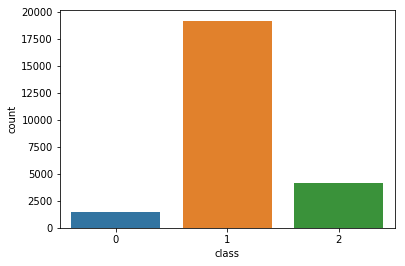

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="class", data=dataset);
plt.show()